# Read Data Sample

In [1]:
import pandas as pd
import numpy as np
from collections import namedtuple
pd.set_option("display.max_rows",35)
%matplotlib inline

In [2]:
class dataset:
    kdd_train_2labels = pd.read_pickle("dataset/kdd_train_2labels.pkl")
    kdd_test_2labels = pd.read_pickle("dataset/kdd_test_2labels.pkl")
    
    kdd_train_5labels = pd.read_pickle("dataset/kdd_train_5labels.pkl")
    kdd_test_5labels = pd.read_pickle("dataset/kdd_test_5labels.pkl")
    

In [3]:
dataset.kdd_train_2labels.shape

(125973, 124)

In [4]:
dataset.kdd_test_2labels.shape

(22544, 124)

In [5]:
from sklearn import model_selection as ms
from sklearn import preprocessing as pp

class preprocess:
    
    output_columns_2labels = ['is_Attack','is_Normal']
    
    x_input = dataset.kdd_train_2labels.drop(output_columns_2labels, axis = 1)
    y_output = dataset.kdd_train_2labels.loc[:,output_columns_2labels]

    x_test_input = dataset.kdd_test_2labels.drop(output_columns_2labels, axis = 1)
    y_test = dataset.kdd_test_2labels.loc[:,output_columns_2labels]

    ss = pp.StandardScaler()

    x_train = ss.fit_transform(x_input)
    x_test = ss.transform(x_test_input)

    y_train = y_output.values
    y_test = y_test.values

preprocess.x_train.shape

(125973, 122)

In [6]:
import tensorflow as tf


In [7]:
class network(object):
    
    input_dim = 122
    classes = 2
    hidden_encoder_dim = 122
    hidden_layers = 1
    latent_dim = 18

    def __init__(self, classes, hidden_layers, num_of_features):
        self.classes = classes
        self.hidden_layers = hidden_layers
        self.latent_dim = num_of_features
            
    def build_layers(self):
        tf.reset_default_graph()
        #learning_rate = tf.Variable(initial_value=0.001)

        input_dim = self.input_dim
        classes = self.classes
        hidden_encoder_dim = self.hidden_encoder_dim
        hidden_layers = self.hidden_layers
        latent_dim = self.latent_dim
        
        with tf.variable_scope("Input"):
            self.x = tf.placeholder("float", shape=[None, input_dim])
            self.y_ = tf.placeholder("float", shape=[None, classes])
            self.keep_prob = tf.placeholder("float")
        
        with tf.variable_scope("Layer_Encoder"):

            hidden_encoder = tf.layers.dense(self.x, hidden_encoder_dim, activation = tf.nn.relu, kernel_regularizer=tf.nn.l2_loss)
            hidden_encoder = tf.nn.dropout(hidden_encoder, self.keep_prob)
            for h in range(hidden_layers - 1):
                hidden_encoder = tf.layers.dense(hidden_encoder, latent_dim, activation = tf.nn.relu, kernel_regularizer=tf.nn.l2_loss)
                hidden_encoder = tf.nn.dropout(hidden_encoder, self.keep_prob)
            
            #hidden_encoder = tf.layers.dense(self.x, latent_dim, activation = tf.nn.relu, kernel_regularizer=tf.nn.l2_loss)
            #hidden_encoder = tf.nn.dropout(hidden_encoder, self.keep_prob)
            
        with tf.variable_scope("Layer_Dense_Softmax"):
            self.y = tf.layers.dense(hidden_encoder, classes, activation=tf.nn.softmax)
            
        with tf.variable_scope("Loss"):
            
            loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels = self.y_, logits = self.y))

            #loss = tf.clip_by_value(loss, -1e-1, 1e-1)
            #loss = tf.where(tf.is_nan(loss), 1e-1, loss)
            #loss = tf.where(tf.equal(loss, -1e-1), tf.random_normal(loss.shape), loss)
            #loss = tf.where(tf.equal(loss, 1e-1), tf.random_normal(loss.shape), loss)
            
            self.regularized_loss = loss
            correct_prediction = tf.equal(tf.argmax(self.y_, 1), tf.argmax(self.y, 1))
            self.tf_accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32), name = "Accuracy")

        with tf.variable_scope("Optimizer"):
            learning_rate=1e-5
            optimizer = tf.train.AdamOptimizer(learning_rate)
            gradients, variables = zip(*optimizer.compute_gradients(self.regularized_loss))
            gradients = [
                None if gradient is None else tf.clip_by_value(gradient, -1, 1)
                for gradient in gradients]
            self.train_op = optimizer.apply_gradients(zip(gradients, variables))
            #self.train_op = optimizer.minimize(self.regularized_loss)
            
        # add op for merging summary
        #self.summary_op = tf.summary.merge_all()
        self.pred = tf.argmax(self.y, axis = 1)
        self.actual = tf.argmax(self.y_, axis = 1)

        # add Saver ops
        self.saver = tf.train.Saver()
        

In [8]:
import collections

class Train:    
    
    result = namedtuple("score", ['epoch', 'no_of_features','hidden_layers','train_score', 'test_score'])

    predictions = {}

    results = []
    best_acc = 0
    
    def train(epochs, net, h,f):
        batch_iterations = 200
    
        with tf.Session() as sess:
            #summary_writer_train = tf.summary.FileWriter('./logs/kdd/VAE/training', graph=sess.graph)
            #summary_writer_valid = tf.summary.FileWriter('./logs/kdd/VAE/validation')

            sess.run(tf.global_variables_initializer())

            for epoch in range(1, (epochs+1)):
                x_train, x_valid, y_train, y_valid, = ms.train_test_split(preprocess.x_train, 
                                                                          preprocess.y_train, 
                                                                          test_size=0.1)
                batch_indices = np.array_split(np.arange(x_train.shape[0]), 
                                           batch_iterations)
                                                                          
                for i in batch_indices:
                    _, train_loss = sess.run([net.train_op, 
                                                           net.regularized_loss, 
                                                           ], #net.summary_op
                                                          feed_dict={net.x: x_train[i,:], 
                                                                     net.y_: y_train[i,:], 
                                                                     net.keep_prob:0.5})
                    
                    #summary_writer_train.add_summary(summary_str, epoch)
                    if(train_loss > 1e9):
                        print("Step {} | Training Loss: {:.6f}".format(epoch, train_loss))
                    

                valid_accuracy = sess.run(net.tf_accuracy, #net.summary_op 
                                                      feed_dict={net.x: x_valid, 
                                                                 net.y_: y_valid, 
                                                                 net.keep_prob:1})
                #summary_writer_valid.add_summary(summary_str, epoch)

                
                accuracy, pred_value, actual_value, y_pred = sess.run([net.tf_accuracy, 
                                                               net.pred, 
                                                               net.actual, net.y], 
                                                              feed_dict={net.x: preprocess.x_test, 
                                                                         net.y_: preprocess.y_test, 
                                                                         net.keep_prob:1})

                print("Step {} | Training Loss: {:.6f} | Validation Accuracy: {:.6f}".format(epoch, train_loss, valid_accuracy))
                print("Accuracy on Test data: {}".format(accuracy))

                if accuracy > Train.best_acc:
                    Train.best_acc = accuracy
                    Train.pred_value = pred_value
                    Train.actual_value = actual_value
                    Train.best_parameters = "Hidden Layers:{}, Features Count:{}".format(h, f)
                    net.saver.save(sess, 
                                   "dataset/tf_dense_only_nsl_kdd_hidden layers_{}_features count_{}".format(h,f),
                                    global_step = epochs)
                    curr_pred = pd.DataFrame({"Attack_prob":y_pred[:,-2], "Normal_prob":y_pred[:, -1]})
                    Train.predictions.update({"{}_{}_{}".format(epochs,f,h):curr_pred})

                    Train.results.append(Train.result(epochs, f, h,valid_accuracy, accuracy))
            

In [9]:
import itertools
class Hyperparameters:
#    features_arr = [2, 4, 8, 16, 32, 64, 128, 256]
#    hidden_layers_arr = [2, 4, 6, 10]
    features_arr = [4, 8, 32, 64]
    hidden_layers_arr = [4, 6]

    epochs = [100]
    
    for e, h, f in itertools.product(epochs, hidden_layers_arr, features_arr):
        print("Current Layer Attributes - epochs:{} hidden layers:{} features count:{}".format(e,h,f))
        n = network(2,h,f)
        n.build_layers()
        Train.train(e, n, h,f)
        

Current Layer Attributes - epochs:100 hidden layers:4 features count:4
Step 1 | Training Loss: 0.681097 | Validation Accuracy: 0.718844
Accuracy on Test data: 0.5996273756027222
Step 2 | Training Loss: 0.683299 | Validation Accuracy: 0.801080
Accuracy on Test data: 0.6605748534202576
Step 3 | Training Loss: 0.682867 | Validation Accuracy: 0.815764
Accuracy on Test data: 0.6569375395774841
Step 4 | Training Loss: 0.682487 | Validation Accuracy: 0.819971
Accuracy on Test data: 0.6472232341766357
Step 5 | Training Loss: 0.675851 | Validation Accuracy: 0.844261
Accuracy on Test data: 0.6533445715904236
Step 6 | Training Loss: 0.674450 | Validation Accuracy: 0.872916
Accuracy on Test data: 0.7317246198654175
Step 7 | Training Loss: 0.664040 | Validation Accuracy: 0.896015
Accuracy on Test data: 0.7506210207939148
Step 8 | Training Loss: 0.658958 | Validation Accuracy: 0.913558
Accuracy on Test data: 0.7605571150779724
Step 9 | Training Loss: 0.661027 | Validation Accuracy: 0.924988
Accuracy

Step 77 | Training Loss: 0.597299 | Validation Accuracy: 0.967138
Accuracy on Test data: 0.7810947299003601
Step 78 | Training Loss: 0.582857 | Validation Accuracy: 0.966185
Accuracy on Test data: 0.7808729410171509
Step 79 | Training Loss: 0.584016 | Validation Accuracy: 0.968408
Accuracy on Test data: 0.7809616923332214
Step 80 | Training Loss: 0.588315 | Validation Accuracy: 0.968646
Accuracy on Test data: 0.7810060381889343
Step 81 | Training Loss: 0.591915 | Validation Accuracy: 0.966026
Accuracy on Test data: 0.7809173464775085
Step 82 | Training Loss: 0.578645 | Validation Accuracy: 0.968011
Accuracy on Test data: 0.7806068062782288
Step 83 | Training Loss: 0.581369 | Validation Accuracy: 0.968884
Accuracy on Test data: 0.7806511521339417
Step 84 | Training Loss: 0.596540 | Validation Accuracy: 0.967058
Accuracy on Test data: 0.7802963256835938
Step 85 | Training Loss: 0.580330 | Validation Accuracy: 0.966185
Accuracy on Test data: 0.779985785484314
Step 86 | Training Loss: 0.58

Step 53 | Training Loss: 0.522926 | Validation Accuracy: 0.969836
Accuracy on Test data: 0.7740418910980225
Step 54 | Training Loss: 0.517373 | Validation Accuracy: 0.968090
Accuracy on Test data: 0.7730216383934021
Step 55 | Training Loss: 0.511441 | Validation Accuracy: 0.969043
Accuracy on Test data: 0.7721344828605652
Step 56 | Training Loss: 0.522776 | Validation Accuracy: 0.968566
Accuracy on Test data: 0.7718240022659302
Step 57 | Training Loss: 0.515366 | Validation Accuracy: 0.968328
Accuracy on Test data: 0.771025538444519
Step 58 | Training Loss: 0.507282 | Validation Accuracy: 0.969836
Accuracy on Test data: 0.7696948051452637
Step 59 | Training Loss: 0.527852 | Validation Accuracy: 0.967217
Accuracy on Test data: 0.7688964009284973
Step 60 | Training Loss: 0.515176 | Validation Accuracy: 0.969916
Accuracy on Test data: 0.7676100134849548
Step 61 | Training Loss: 0.515883 | Validation Accuracy: 0.969043
Accuracy on Test data: 0.7670333385467529
Step 62 | Training Loss: 0.51

Step 29 | Training Loss: 0.424114 | Validation Accuracy: 0.958724
Accuracy on Test data: 0.7806511521339417
Step 30 | Training Loss: 0.404148 | Validation Accuracy: 0.956739
Accuracy on Test data: 0.779985785484314
Step 31 | Training Loss: 0.424002 | Validation Accuracy: 0.958168
Accuracy on Test data: 0.7787438035011292
Step 32 | Training Loss: 0.411622 | Validation Accuracy: 0.956342
Accuracy on Test data: 0.7767033576965332
Step 33 | Training Loss: 0.395796 | Validation Accuracy: 0.961105
Accuracy on Test data: 0.7754169702529907
Step 34 | Training Loss: 0.403996 | Validation Accuracy: 0.957850
Accuracy on Test data: 0.7751508355140686
Step 35 | Training Loss: 0.389845 | Validation Accuracy: 0.961105
Accuracy on Test data: 0.7746185064315796
Step 36 | Training Loss: 0.398625 | Validation Accuracy: 0.961026
Accuracy on Test data: 0.7736870050430298
Step 37 | Training Loss: 0.385626 | Validation Accuracy: 0.962613
Accuracy on Test data: 0.7726668119430542
Step 38 | Training Loss: 0.37

Step 5 | Training Loss: 0.632847 | Validation Accuracy: 0.930148
Accuracy on Test data: 0.813342809677124
Step 6 | Training Loss: 0.605739 | Validation Accuracy: 0.938085
Accuracy on Test data: 0.8152945637702942
Step 7 | Training Loss: 0.589402 | Validation Accuracy: 0.942292
Accuracy on Test data: 0.8154276013374329
Step 8 | Training Loss: 0.546290 | Validation Accuracy: 0.947769
Accuracy on Test data: 0.8147178888320923
Step 9 | Training Loss: 0.553200 | Validation Accuracy: 0.952532
Accuracy on Test data: 0.8147622346878052
Step 10 | Training Loss: 0.513729 | Validation Accuracy: 0.954834
Accuracy on Test data: 0.8134315013885498
Step 11 | Training Loss: 0.509545 | Validation Accuracy: 0.950786
Accuracy on Test data: 0.8113910555839539
Step 12 | Training Loss: 0.480176 | Validation Accuracy: 0.953247
Accuracy on Test data: 0.8094393014907837
Step 13 | Training Loss: 0.473095 | Validation Accuracy: 0.956183
Accuracy on Test data: 0.8066004514694214
Step 14 | Training Loss: 0.458193 

Step 81 | Training Loss: 0.336424 | Validation Accuracy: 0.976663
Accuracy on Test data: 0.7527945637702942
Step 82 | Training Loss: 0.339816 | Validation Accuracy: 0.975790
Accuracy on Test data: 0.75288325548172
Step 83 | Training Loss: 0.350864 | Validation Accuracy: 0.975552
Accuracy on Test data: 0.75288325548172
Step 84 | Training Loss: 0.342899 | Validation Accuracy: 0.974599
Accuracy on Test data: 0.7528389096260071
Step 85 | Training Loss: 0.344312 | Validation Accuracy: 0.974520
Accuracy on Test data: 0.7528389096260071
Step 86 | Training Loss: 0.335077 | Validation Accuracy: 0.973091
Accuracy on Test data: 0.7527501583099365
Step 87 | Training Loss: 0.338147 | Validation Accuracy: 0.976028
Accuracy on Test data: 0.7526614665985107
Step 88 | Training Loss: 0.331838 | Validation Accuracy: 0.975710
Accuracy on Test data: 0.7523509860038757
Step 89 | Training Loss: 0.335126 | Validation Accuracy: 0.975472
Accuracy on Test data: 0.7524396777153015
Step 90 | Training Loss: 0.34800

Step 56 | Training Loss: 0.680730 | Validation Accuracy: 0.528020
Accuracy on Test data: 0.43075764179229736
Step 57 | Training Loss: 0.687763 | Validation Accuracy: 0.537149
Accuracy on Test data: 0.43075764179229736
Step 58 | Training Loss: 0.684347 | Validation Accuracy: 0.546357
Accuracy on Test data: 0.43075764179229736
Step 59 | Training Loss: 0.677017 | Validation Accuracy: 0.534609
Accuracy on Test data: 0.43075764179229736
Step 60 | Training Loss: 0.679873 | Validation Accuracy: 0.532704
Accuracy on Test data: 0.43075764179229736
Step 61 | Training Loss: 0.678963 | Validation Accuracy: 0.533656
Accuracy on Test data: 0.43075764179229736
Step 62 | Training Loss: 0.680195 | Validation Accuracy: 0.528179
Accuracy on Test data: 0.43075764179229736
Step 63 | Training Loss: 0.685780 | Validation Accuracy: 0.532465
Accuracy on Test data: 0.43075764179229736
Step 64 | Training Loss: 0.684111 | Validation Accuracy: 0.538022
Accuracy on Test data: 0.43075764179229736
Step 65 | Training 

Step 31 | Training Loss: 0.682495 | Validation Accuracy: 0.813621
Accuracy on Test data: 0.5906671285629272
Step 32 | Training Loss: 0.674351 | Validation Accuracy: 0.821400
Accuracy on Test data: 0.6153743863105774
Step 33 | Training Loss: 0.681253 | Validation Accuracy: 0.833942
Accuracy on Test data: 0.6855925917625427
Step 34 | Training Loss: 0.667842 | Validation Accuracy: 0.857200
Accuracy on Test data: 0.7356724739074707
Step 35 | Training Loss: 0.669939 | Validation Accuracy: 0.870853
Accuracy on Test data: 0.7463183403015137
Step 36 | Training Loss: 0.676611 | Validation Accuracy: 0.879584
Accuracy on Test data: 0.7519074082374573
Step 37 | Training Loss: 0.677946 | Validation Accuracy: 0.888077
Accuracy on Test data: 0.7575851678848267
Step 38 | Training Loss: 0.665614 | Validation Accuracy: 0.886252
Accuracy on Test data: 0.7623757719993591
Step 39 | Training Loss: 0.673300 | Validation Accuracy: 0.897603
Accuracy on Test data: 0.76698899269104
Step 40 | Training Loss: 0.665

Step 7 | Training Loss: 0.698972 | Validation Accuracy: 0.807350
Accuracy on Test data: 0.8469659090042114
Step 8 | Training Loss: 0.698362 | Validation Accuracy: 0.819813
Accuracy on Test data: 0.8481636047363281
Step 9 | Training Loss: 0.692390 | Validation Accuracy: 0.826163
Accuracy on Test data: 0.8480305075645447
Step 10 | Training Loss: 0.690116 | Validation Accuracy: 0.840610
Accuracy on Test data: 0.8489620089530945
Step 11 | Training Loss: 0.669885 | Validation Accuracy: 0.849262
Accuracy on Test data: 0.8522001504898071
Step 12 | Training Loss: 0.663251 | Validation Accuracy: 0.850135
Accuracy on Test data: 0.8535308837890625
Step 13 | Training Loss: 0.646792 | Validation Accuracy: 0.867916
Accuracy on Test data: 0.8578779101371765
Step 14 | Training Loss: 0.663005 | Validation Accuracy: 0.867836
Accuracy on Test data: 0.8592086434364319
Step 15 | Training Loss: 0.656947 | Validation Accuracy: 0.872281
Accuracy on Test data: 0.8607611656188965
Step 16 | Training Loss: 0.6508

Step 84 | Training Loss: 0.357013 | Validation Accuracy: 0.963010
Accuracy on Test data: 0.7939141392707825
Step 85 | Training Loss: 0.357771 | Validation Accuracy: 0.968249
Accuracy on Test data: 0.7939141392707825
Step 86 | Training Loss: 0.366857 | Validation Accuracy: 0.964836
Accuracy on Test data: 0.7937366962432861
Step 87 | Training Loss: 0.381985 | Validation Accuracy: 0.964994
Accuracy on Test data: 0.793470561504364
Step 88 | Training Loss: 0.361715 | Validation Accuracy: 0.964518
Accuracy on Test data: 0.7936035990715027
Step 89 | Training Loss: 0.366785 | Validation Accuracy: 0.965868
Accuracy on Test data: 0.7933818101882935
Step 90 | Training Loss: 0.376252 | Validation Accuracy: 0.965074
Accuracy on Test data: 0.7934262156486511
Step 91 | Training Loss: 0.347939 | Validation Accuracy: 0.966900
Accuracy on Test data: 0.7932931184768677
Step 92 | Training Loss: 0.365896 | Validation Accuracy: 0.969281
Accuracy on Test data: 0.792317271232605
Step 93 | Training Loss: 0.362

Step 60 | Training Loss: 0.367254 | Validation Accuracy: 0.968884
Accuracy on Test data: 0.7731547355651855
Step 61 | Training Loss: 0.380112 | Validation Accuracy: 0.967455
Accuracy on Test data: 0.7731990814208984
Step 62 | Training Loss: 0.347035 | Validation Accuracy: 0.967455
Accuracy on Test data: 0.77275550365448
Step 63 | Training Loss: 0.362435 | Validation Accuracy: 0.967852
Accuracy on Test data: 0.771025538444519
Step 64 | Training Loss: 0.357439 | Validation Accuracy: 0.968170
Accuracy on Test data: 0.7708925008773804
Step 65 | Training Loss: 0.349743 | Validation Accuracy: 0.965947
Accuracy on Test data: 0.7709811925888062
Step 66 | Training Loss: 0.362328 | Validation Accuracy: 0.969360
Accuracy on Test data: 0.7706707119941711
Step 67 | Training Loss: 0.362992 | Validation Accuracy: 0.969440
Accuracy on Test data: 0.7704045176506042
Step 68 | Training Loss: 0.351573 | Validation Accuracy: 0.969836
Accuracy on Test data: 0.7699165940284729
Step 69 | Training Loss: 0.3518

In [10]:
df_results = pd.DataFrame(Train.results)

In [11]:
df_results.sort_values(by = 'test_score', ascending = False)

,epoch,no_of_features,hidden_layers,train_score,test_score
27,100,32,6,0.934672,0.904010
26,100,32,6,0.936180,0.903744
25,100,32,6,0.930148,0.903167
24,100,32,6,0.925703,0.897090
23,100,32,6,0.921416,0.890747
22,100,64,4,0.833386,0.884493
21,100,4,4,0.956660,0.835832
20,100,4,4,0.954517,0.835566
19,100,4,4,0.954437,0.834989
18,100,4,4,0.948484,0.834457


In [12]:
pd.Panel(Train.predictions).to_pickle("dataset/tf_dense_only_nsl_kdd_predictions.pkl")
df_results.to_pickle("dataset/tf_dense_only_nsl_kdd_scores.pkl")

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    np.set_printoptions(precision=4)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j].round(4),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def plot(actual_value, pred_value):
    from sklearn.metrics import confusion_matrix
    cm_2labels = confusion_matrix(y_pred = pred_value, y_true = actual_value)
    plt.figure(figsize=[6,6])
    plot_confusion_matrix(cm_2labels, preprocess.output_columns_2labels, normalize = True,
                         title = Train.best_parameters)

Normalized confusion matrix
[[ 0.8675  0.1325]
 [ 0.0478  0.9522]]


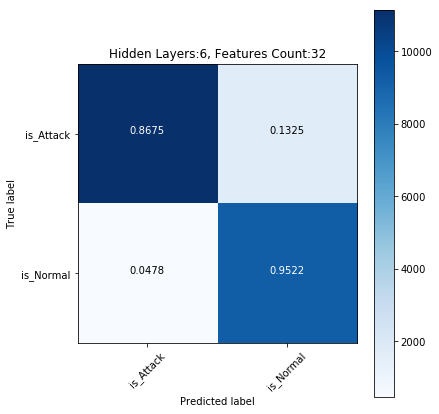

In [14]:
plot(actual_value = Train.actual_value, pred_value = Train.pred_value)